# Visualising FITS and star positions

In [44]:
import requests, math, glob
import pandas as pd
import numpy as np
from photutils import DAOStarFinder
from astropy.stats import mad_std
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from photutils import aperture_photometry, CircularAperture
#from astroquery.simbad import Simbad
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn')
pd.options.mode.chained_assignment = None


In [53]:
import os
os.chdir('/home/jovyan/work')
import init
import reading
import do_calibration

In [54]:
def getWcs(wcs_file):
    hdulist = fits.open(wcs_file)
    data = hdulist[0].data.astype(float)
    header = hdulist[0].header
    wcs = WCS(header)
    return wcs

FITS_FILE=init.fitsdir+init.reference_frame
wcs_file = init.basedir+"new-image.fits"
print(os.getcwd())
wcs = getWcs(wcs_file)
vsx = do_calibration.getVSX(init.basedir+'SearchResults.csv')
candidates = do_calibration.getCandidates(0.7)
detections = reading.read_world_positions(init.worldposdir)

#x_pix, y_pix = wcs.all_world2pix(ra_deg, dec_deg)
# x_world, y_world = gc.pixel2world(np.array([700]), np.array([700]))

/home/jovyan/work


In [55]:
# auid	dec	error	peak	ra	vmag	x	y

results = []
found_results = []

for variable in vsx:
    results.append({'auid': variable[0], 'coord': variable[1]})

for key in detections:
    found_results.append({'auid': str(key), 'coord': SkyCoord(detections[key][0], detections[key][1], unit='deg')})
    
#for candidate in candidates:
#    found_results.append({'auid': str(candidate[0]), 'coord': candidate[4]})


def add_pixels(results, offset):
    for star in results:
        star_coord = star['coord']
        xy = SkyCoord.to_pixel(star_coord, wcs=wcs, origin=1)
        x = xy[0].item(0)
        y = xy[1].item(0)
        star['x'] = x + offset
        star['y'] = y + offset
    results = pd.DataFrame(results)
    return results
results = add_pixels(results, 1000)
found_results = add_pixels(found_results, 1000)
print(len(found_results))
print(found_results)

9999
      auid                                              coord            x  \
0        1  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.2...  1718.331388   
1        2  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.0...  1464.321325   
2        3  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.1...  1636.431314   
3        4  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.6...  2283.171470   
4        5  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.0...  1482.221353   
5        6  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.2...  1782.201342   
6        7  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.4...  2032.281514   
7        8  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.0...  1506.811296   
8        9  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.3...  1848.771303   
9       10  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.4...  2051.471382   
10      11  <SkyCoord (ICRS): (ra, dec) in deg\n    (271.4...  1965.451399   
11      12  <SkyCoord (ICRS): (ra, dec) in deg\n    (270.6.

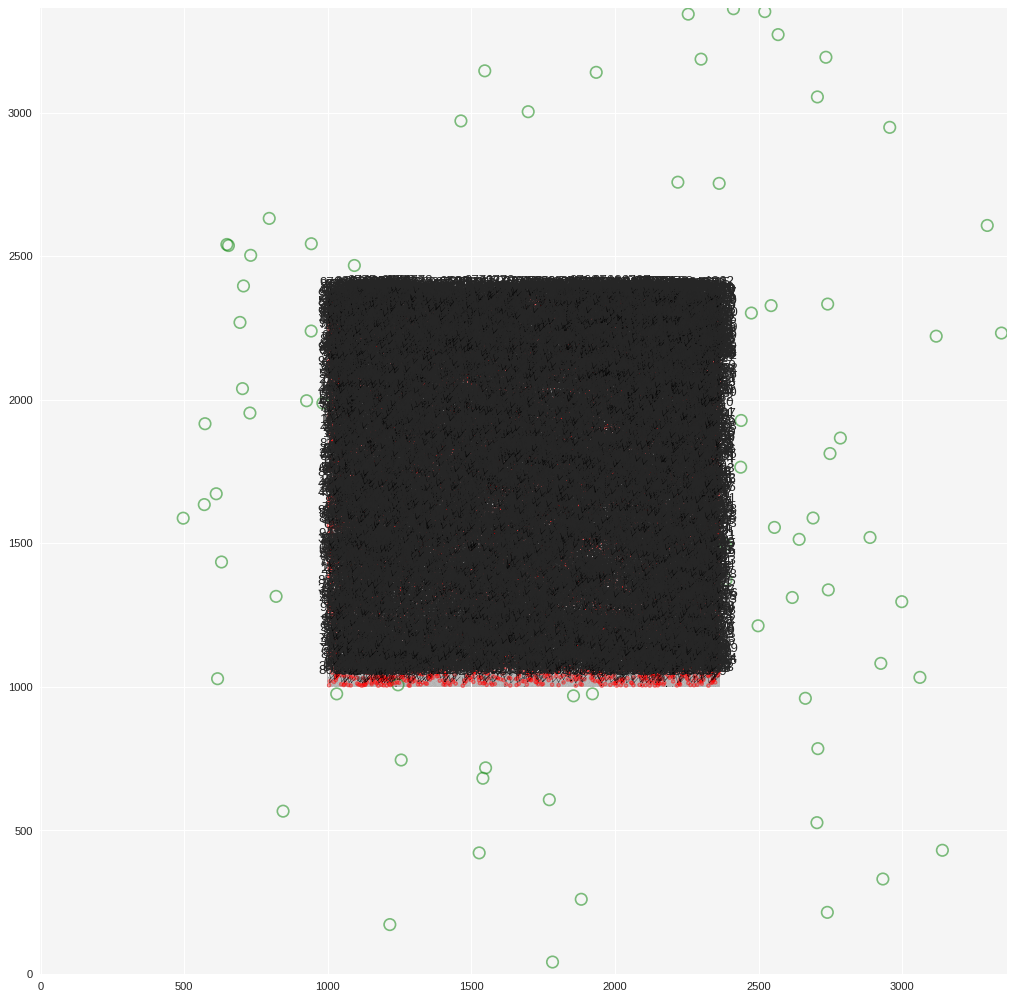

In [56]:
hdulist = fits.open(FITS_FILE)
data = hdulist[0].data.astype(float)
data = np.pad(data, (1000,1000), 'constant', constant_values=(100, 100))
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
known_positions = (results['x'], results['y'])    
found_positions = (found_results['x'], found_results['y'])
known_apps = CircularAperture(known_positions, r=20.)    
found_apps = CircularAperture(found_positions, r=5.)    
# target_app = CircularAperture(target_xy, r=20.)    
plt.imshow(data, cmap='gray_r', origin='lower', vmin=0, vmax=2500)
known_apps.plot(color='green', lw=1.5, alpha=0.5)
found_apps.plot(color='red', lw=1.5, alpha=0.5)
# target_app.plot(color='blue', lw=1.5, alpha=0.5)
#to_plot = results
def annotate_it(results, offset1, offset2, size=16):
    for to_annotate in results.iterrows():
        plt.annotate('{}'.format(to_annotate[1]['auid']),
            xy=(to_annotate[1]['x'], to_annotate[1]['y']), xycoords='data',
            xytext=(offset1, offset2), textcoords='offset points', size=size,
            arrowprops=dict(arrowstyle="->"))
#annotate_it(results, -150, 130, size=10)    
annotate_it(found_results, -10, 10, 12)    


In [39]:
fig.savefig(init.basedir+'results')

## Draw all 1000 stars